In [3]:
!conda activate wheat

In [5]:
import os
import gc
import numpy as np
from numpy.fft import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pywt 
from statsmodels.robust import mad
import scipy
import warnings
from typing import Iterable, List, Optional, Tuple
from scipy import signal
from scipy.signal import decimate, butter, sosfilt, deconvolve

warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
import sys
sys.path.append('..')

In [13]:
from src.helpers.helpers import load_patient_data, plot_ctg, plot_fhr, plot_fhr_time, get_ctg_sizes
from src.helpers.preprocess import *

In [14]:
DATA_DIR = '../../data/database/database/signals'
META_FILE = '../meta.csv'
RESULTS_DIR = '../../output/pics'

In [15]:
df_train = pd.read_csv(META_FILE)
df_train = df_train.drop(['Unnamed: 0'], axis = 1)
df_train.head()

,patient,pH,BDecf,pCO2,BE,Apgar1,Apgar5,Gest. weeks,Weight(g),Sex,...,Induced,I.stage,NoProgress,CK/KP,II.stage,Deliv. type,dbID,Rec. type,Pos. II.st.,target
0,1220,7.30,3.52,6.0,-4.7,9.0,10.0,42.0,3100.0,2.0,...,1.0,165.0,0.0,0.0,15.0,1.0,1051632.0,2.0,14400.0,0
1,1234,7.29,2.50,6.5,-4.2,8.0,9.0,41.0,3200.0,1.0,...,0.0,135.0,0.0,0.0,10.0,1.0,1054195.0,1.0,14400.0,0
2,1208,7.23,5.84,6.6,-7.4,9.0,9.0,40.0,3900.0,2.0,...,0.0,260.0,0.0,0.0,30.0,1.0,1049536.0,12.0,14400.0,0
3,1038,7.33,2.72,5.7,-4.0,10.0,10.0,39.0,2740.0,1.0,...,0.0,15.0,0.0,0.0,10.0,1.0,1002508.0,1.0,14400.0,0
4,1004,7.30,5.19,5.5,-6.4,8.0,9.0,41.0,3370.0,1.0,...,1.0,55.0,0.0,0.0,10.0,1.0,983277.0,12.0,14400.0,0


In [16]:
patients = df_train['patient'].values

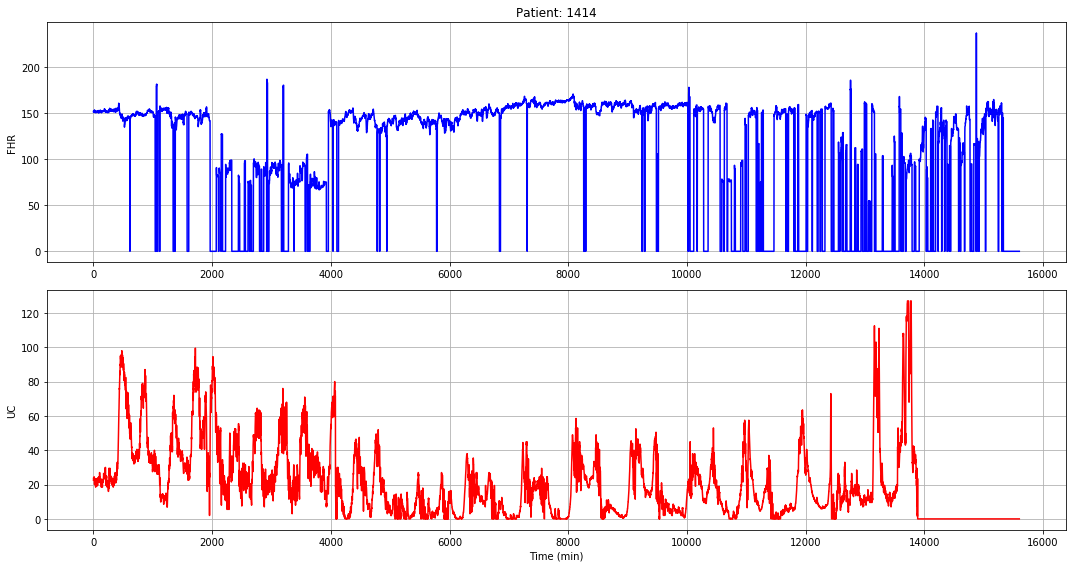

In [17]:
num = 17
patient = patients[num]
fhr, uc, time = load_patient_data(DATA_DIR, int(patient))
fig = plot_ctg(fhr, uc, patient_num = patient) 

In [18]:
fhr1, uc1, time1, assess, missing_part = preprocess_ctg_feat(DATA_DIR, patient, df_train, stage = 1)
fig = plot_ctg(fhr1, uc1, patient_num = patient)
assess, missing_part, len(fhr1)

NameError: name 'preprocess_ctg_feat' is not defined

Wavelet denoising

Wavelet denoising (usually used with electric signals) is a way to remove the unnecessary noise from a time series. This method calculates coefficients called the "wavelet coefficients". These coefficients decide which pieces of information to keep (signal) and which ones to discard (noise).

We make use of the MAD (mean absolute deviation) value to understand the randomness in the sales and accordingly decide the minimum threshold for the wavelet coefficients in the time series. We filter out the low coefficients from the wavelets and reconstruct the sales data from the remaining coefficients and that's it; we have successfully removed noise from the sales data.

**Frequency filters**

In [6]:
def _butter_lowpass(cutoff: float, fs: float = 4, order: int = 5) -> np.array:
    """
    Butterworth digital filter design.
    Design an Nth-order bandpass Butterworth filter and return the filter coefficients.

    Args:
        cutoff: (float) high frequency cut-off
        fs: (int) sampling frequency. Default = 4 Hz
        order: (int) filter order. Default = 5

    Output: (ndarray) second-order sections representation of the IIR filter
    """
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    sos = butter(order, norm_cutoff, btype="lowpass", analog=False, output="sos")
    
    return sos 

    
def _butter_highpass(cutoff: float, fs: float = 4, order: int = 5) -> np.array:
    """
    Butterworth digital filter design.
    Design an Nth-order bandpass Butterworth filter and return the filter coefficients.

    Args:
        cutoff: (float) low frequency cut-off
        fs: (int) sampling frequency. Default = 4 Hz
        order: (int) filter order. Default = 5

    Output: (ndarray) second-order sections representation of the IIR filter
    """
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    sos = butter(order, norm_cutoff, btype="highpass", analog=False, output="sos")
    
    return sos 


def _butter_bandpass(lowcut: float, highcut: float, fs: float = 4, order: int = 5) -> np.array:
    """
    Butterworth digital and analog filter design.
    Design an Nth-order bandpass Butterworth filter and return the filter coefficients.

    Args:
        lowcut: (float) low cut-off frequency 
        highcut: (float) high cut-off frequency 
        fs: (int) sampling frequency. Default = 4 Hz
        order: (int) filter order. Default = 5

    Output: (ndarray) second-order sections representation of the IIR filter
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype="bandpass", output="sos")
    
    return sos     


def bandpass_filter(signal: np.array, lowcut: float, highcut: float, fs: float = 4, order: int = 5):
    """
    Apply Butterworth bandpath filter to a signal.
    
    Args:
        signal: (np.array) 1D signal
        lowcut: (float) low cut-off frequency 
        highcut: (float) high cut-off frequency 
        fs: (int) sampling frequency. Default = 4 Hz
        order: (int) filter order. Default = 5

    Output: (ndarray) filtered signal
    """
    sos = _butter_bandpass(lowcut, highcut, fs, order)
    filtered = sosfilt(sos, signal).astype(np.float32)
    
    return filtered     


def lowpass_filter(signal: np.array, cutoff: float, fs: float = 4, order: int = 5):
    """
    Apply Butterworth bandpath filter to a signal.
    
    Args:
        signal: (np.array) 1D signal
        lowcut: (float) low cut-off frequency 
        highcut: (float) high cut-off frequency 
        fs: (int) sampling frequency. Default = 4 Hz
        order: (int) filter order. Default = 5

    Output: (ndarray) filtered signal
    """
    sos = _butter_lowpass(cutoff, fs, order)
    filtered = sosfilt(sos, signal).astype(np.float32)
    
    return filtered


def highpass_filter(signal: np.array, cutoff: float, fs: float = 4, order: int = 5):
    """
    Apply Butterworth bandpath filter to a signal.
    
    Args:
        signal: (np.array) 1D signal
        lowcut: (float) low cut-off frequency 
        highcut: (float) high cut-off frequency 
        fs: (int) sampling frequency. Default = 4 Hz
        order: (int) filter order. Default = 5

    Output: (ndarray) filtered signal
    """
    sos = _butter_highpass(cutoff, fs, order)
    filtered = sosfilt(sos, signal).astype(np.float32)
    
    return filtered